# SPARK: Resilient Ditributed Data (RDD)

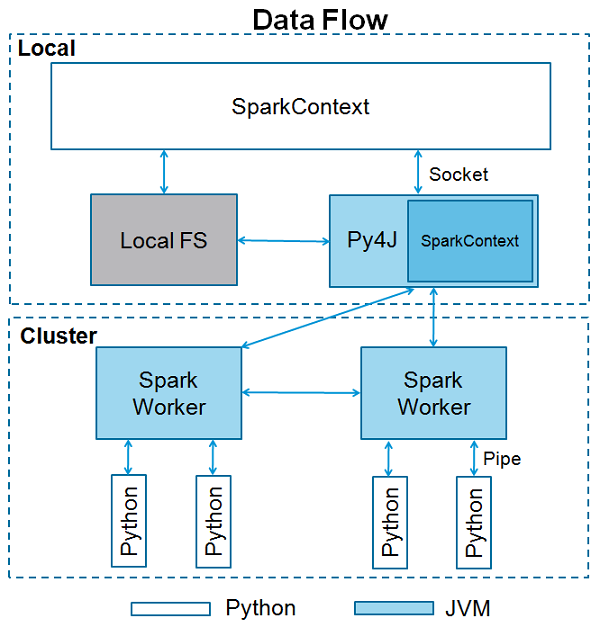

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=aa4b717ecdcabe142350b9192cd25dc787297dda67cf1837288f78599ed879e0
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


### Creating Session and Context

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

### Words counts

In [3]:
import re #for splitting texts

We will use here a toy dataset for explaining the main concepts of RDDs:

In [4]:
text = sc.parallelize(["Humpty Dumpty sat on a wall",\
  	      "Humpty Dumpty had a great fall",\
  	      "All the King's horses and all the King's men",\
          "Couldn't put Humpty together again" ]) #crea rdd con las lineas de texto

In [5]:
def countWords(line):
  D = {}
  for w in re.split('\W+', line.lower().strip()):
    ##Optional: REMOVE MEANINGLESS TOKENS HERE
    if w in D: D[w]+=1
    else: D[w]=1
  return [(w, D[w]) for w in D] #cuenta el numero de palabras en una linia

In [6]:
counts = text.flatMap(countWords) \
             .reduceByKey(lambda a, b: a + b) # calcular cuantas veces aparecen las palabras en el texto
             #es un grafo que no se ha ejecutado.

#counts.coalesce(1).saveAsTextFile("words_counts") #reduce partitions to 1
counts.take(10)

[('dumpty', 2),
 ('sat', 1),
 ('fall', 1),
 ('king', 2),
 ('s', 2),
 ('horses', 1),
 ('couldn', 1),
 ('put', 1),
 ('again', 1),
 ('humpty', 3)]

In [7]:
Vocab = dict([(e[0], i) for (i, e) in enumerate(counts.collect())])
Vocab

{'dumpty': 0,
 'sat': 1,
 'fall': 2,
 'king': 3,
 's': 4,
 'horses': 5,
 'couldn': 6,
 'put': 7,
 'again': 8,
 'humpty': 9,
 'on': 10,
 'a': 11,
 'wall': 12,
 'had': 13,
 'great': 14,
 'all': 15,
 'the': 16,
 'and': 17,
 'men': 18,
 't': 19,
 'together': 20}

We are going to save the file in a CSV, so first we convert the RDD into a Dataframe:

In [8]:
df = counts.toDF().toDF('word','total')

In [9]:
df.take(5) #organiza por registros no por columnas. #los calculos en spark estan orientados a filas

[Row(word='dumpty', total=2),
 Row(word='sat', total=1),
 Row(word='fall', total=1),
 Row(word='king', total=2),
 Row(word='s', total=2)]

In [10]:
df.write.options(header=True).mode('overwrite').csv('./word_counts_csv') #guardamos como csv

### Word probabilities:

First, we calculate the total number of occurrences in all the text:

In [11]:
N = text.map(lambda line: ("total", len(re.split('\W+', line.lower().strip())))) \
        .reduceByKey(lambda a, b: a + b)

total = N.take(1)[0][1]
total

29

Then, we divide all elements by the total occurrences:

In [12]:
total = N.take(1)[0][1]

P = counts.map(lambda x: (x[0], x[1]/total))

P.take(10)

[('dumpty', 0.06896551724137931),
 ('sat', 0.034482758620689655),
 ('fall', 0.034482758620689655),
 ('king', 0.06896551724137931),
 ('s', 0.06896551724137931),
 ('horses', 0.034482758620689655),
 ('couldn', 0.034482758620689655),
 ('put', 0.034482758620689655),
 ('again', 0.034482758620689655),
 ('humpty', 0.10344827586206896)]

**Definition:** The inverse document frequency (IDF) of a word is `-log(count(w)/total)`

Notice that rare words have a high IDF score and very frequent words have a low IDF score. We can filter out words with a extremely low IDF (also called stopwords).

In [13]:
import math

IDF = counts.map(lambda x: (x[0], -math.log(x[1]/total)))

#IDF = P.map(lambda x: (x[0], -math.log(x[1]))) #se pueden las dos formas. Esta utiliza la probabilidad calculada anteriormente.

In [14]:
IDF.take(4)

[('dumpty', 2.6741486494265287),
 ('sat', 3.367295829986474),
 ('fall', 3.367295829986474),
 ('king', 2.6741486494265287)]

### Conditional Probabilities


First, we count bigrams of adjacent words `count(w, w')`

In [15]:
def countBigrams(s):
    D = {}
    words = re.split('\W+', s.lower().strip())
    ##Optional: REMOVE MEANINGLESS TOKENS HERE
    for i in range(len(words) - 1):
        clave = (words[i], words[i + 1])
        if clave in D: D[clave] += 1
        else: D[clave] = 1
    return [(w, D[w]) for w in D] #base de molts models d prediccions de paraules

In [16]:
countBigrams("Humpty Dumpty sat on a wall")

[(('humpty', 'dumpty'), 1),
 (('dumpty', 'sat'), 1),
 (('sat', 'on'), 1),
 (('on', 'a'), 1),
 (('a', 'wall'), 1)]

In [17]:
counts3 = text.flatMap(lambda line: countBigrams(line)) \
              .reduceByKey(lambda a, b: a + b)
counts3.take(10)
'''
[(('dumpty', 'sat'), 1),
 (('on', 'a'), 1),
 (('a', 'wall'), 1),
 (('had', 'a'), 1),
 (('a', 'great'), 1)]
'''

"\n[(('dumpty', 'sat'), 1),\n (('on', 'a'), 1),\n (('a', 'wall'), 1),\n (('had', 'a'), 1),\n (('a', 'great'), 1)]\n"

Now, we take the second word as a key to be able to join with the probs. of words `count(w')`

In [18]:
counts4 = counts3.map(lambda x: (x[0][1], [x[0], x[1]] ))

'''
[('sat', [('dumpty', 'sat'), 1]),
 ('a', [('on', 'a'), 1]),
 ('wall', [('a', 'wall'), 1]),
 ('a', [('had', 'a'), 1]),
 ('great', [('a', 'great'), 1])]
'''

"\n[('sat', [('dumpty', 'sat'), 1]),\n ('a', [('on', 'a'), 1]),\n ('wall', [('a', 'wall'), 1]),\n ('a', [('had', 'a'), 1]),\n ('great', [('a', 'great'), 1])]\n"

Finally, we can calculate `count(w, w')/count(w)` from the previous RDD

In [19]:
conditional = counts4.join(counts) \
                     .map(lambda x: (x[1][0][0], x[1][0][1]/x[1][1]))

'''
join:
[('s', ([('king', 's'), 2], 2)),
 ('dumpty', ([('humpty', 'dumpty'), 2], 2)),
 ('king', ([('the', 'king'), 2], 2)),
 ...
'''

conditional.collect() #probabilidades de ver una palabra si veo la anterior antes.

[(('king', 's'), 1.0),
 (('humpty', 'dumpty'), 1.0),
 (('the', 'king'), 1.0),
 (('t', 'put'), 1.0),
 (('together', 'again'), 1.0),
 (('on', 'a'), 0.5),
 (('had', 'a'), 0.5),
 (('a', 'wall'), 1.0),
 (('a', 'great'), 1.0),
 (('all', 'the'), 1.0),
 (('horses', 'and'), 1.0),
 (('s', 'men'), 1.0),
 (('dumpty', 'sat'), 1.0),
 (('s', 'horses'), 1.0),
 (('great', 'fall'), 1.0),
 (('and', 'all'), 0.5),
 (('humpty', 'together'), 1.0),
 (('sat', 'on'), 1.0),
 (('dumpty', 'had'), 1.0),
 (('couldn', 't'), 1.0),
 (('put', 'humpty'), 0.3333333333333333)]

### DATAFRAMES

In [20]:
words = spark.read.options(header=True)\
             .format("csv")\
             .load("word_counts_csv")

In [21]:
words

DataFrame[word: string, total: string]

In [22]:
rdd = words.rdd

In [23]:
rdd.map(lambda x: (x.word , x.total) ).take(1)

[('humpty', '3')]

In [24]:
#We can also convert a RDD to a Pandas dataframe

df_pandas = words.toPandas()

df_pandas.head()

,word,total
0,humpty,3
1,on,1
2,a,2
3,wall,1
4,had,1


## Exercise

Give the compressed CSV available at `http://krono.act.uji.es/IDIA/criticas_pelis.csv.gz`, our aim is to tranform this data into *sparse vectors* suited for machine learning algorithms of Spark. The vector of each document will be represented with the following string:

`word_1:score_1 word_2:score_2 ...`

Where *word_i* is the position of the word in the list of all the words in the CSV, and *score_i* is the TFxIDF score. The TF is frequency of the *word_i* in the document, and the IDF is the inverse document frequecy of the *word_i* (see definition above).

Finally, we will write this data into a LIBSVM text file. This file consists of a labelled sample per line, where each sample has the following format:

`label word_1:score_1 word_2:score_2 ...`

To perform this task, you can follow the following steps:

**Step 1.** Load the CSV file as a Spark Dataframe, and assign as the ID of each document the position of its row.

In [25]:
#Step 1
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
!wget http://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
!gunzip criticas_pelis.csv.gz

--2023-10-27 14:25:29--  http://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
Resolving krono.act.uji.es (krono.act.uji.es)... 150.128.97.37
Connecting to krono.act.uji.es (krono.act.uji.es)|150.128.97.37|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz [following]
--2023-10-27 14:25:29--  https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
Connecting to krono.act.uji.es (krono.act.uji.es)|150.128.97.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4447654 (4.2M) [application/x-gzip]
Saving to: ‘criticas_pelis.csv.gz’

criticas_pelis.csv. 100%[===================>]   4.24M  4.24MB/s    in 1.0s    

2023-10-27 14:25:30 (4.24 MB/s) - ‘criticas_pelis.csv.gz’ saved [4447654/4447654]



In [26]:
##Step 1
#We read the data
df = spark.read.options(header=False)\
            .format("csv")\
            .load("./criticas_pelis.csv")

In [27]:
#Step 1
from pyspark.sql.functions import monotonically_increasing_id
df = df.withColumnRenamed("_c0", "id")
df = df.select("*").withColumn("id", monotonically_increasing_id())
df = df.withColumnRenamed("_c3", "label")

In [28]:
df.show(5)

+---+---------+--------------------+-----+
| id|      _c1|                 _c2|label|
+---+---------+--------------------+-----+
|  0|   File-0| May, ¿quieres se...|    4|
|  1|   File-1| Cómo ponerse en ...|    4|
|  2|  File-10| Deliciosa comedi...|    4|
|  3| File-100| La ironía es el ...|    3|
|  4|File-1000| Al final, y teni...|    3|
+---+---------+--------------------+-----+
only showing top 5 rows



**Step 2.** Build an RDD to calculate the IDFs of all the words in the CSV

In [29]:
## Step 2
# Transform the dataframe into rdd
df_rdd = df.rdd

#we count the number of times that a word appear in the document
counts = df_rdd.flatMap(lambda c: countWords(c['_c2'])).reduceByKey(lambda a, b: a + b)

# calculate the number of words
total = counts.values().sum()

#create a RDD with the worlds and the probabilities.
P = counts.map(lambda x: (x[0], x[1]/total))

#create a RDD with the worlds and the IDF
IDF = P.map(lambda x: (x[0], -math.log(x[1])))

**Step 3.** Build a Python dictionary to store the position and IDF of each word in the previous RDD. Word position corresponds to the index on the ordered list of all words in the CSV.

For example, if we name the dictionary `Vocab`, `Vocab["always"]` contains a tuple like `(1234, 3.2)`, where 1234 is the position of "always" in the ordered list of all the words in the CSV, and 3.2 is the IDF score of "always" according to the RDD of Step 2.

In [30]:
## Step 3
Vocab = dict([(word, (position, idf)) for position, (word, idf) in enumerate(IDF.collect())])

**Step 4.** Build an RDD with the words' scores of each document

You can modify the function `countWords(line)` and use the dictionary of Step 3
to obtain the position (word_id) and the IDF of each word in the document.

*Output*: key-value pairs `((doc_id, word_id), tf*IDF)`

In [31]:
def countWordsScores(line):
  D = {}
  for w in re.split('\W+', line['_c2'].lower().strip()):
    #if(not w.isalpha()):
      #continue # REMOVE MEANINGLESS TOKENS HERE // If not valid skip and don't add it to the list
    if w in D: D[w]+=1
    else: D[w]=1
    ##D[w] is the TF
  return [((line['id'],Vocab[w][0]), D[w]*Vocab[w][1]) for w in D]

#create de rdd with the scores
scores_rdd = df_rdd.flatMap(lambda c: countWordsScores(c))

**Step 5**. Map and Reduce by document to create an ordered list of the words' ids along with their TF*IDF scores

*Output*: key-value pairs `(doc_id, [(word_1, score_1), (word_2, score_2)])`

In [32]:
## Step 5

#first we create a rdd to take the doc_id and its word with its scores
order_rdd = scores_rdd.map(lambda x: (x[0][0], [(x[0][1], x[1])]))

# we group by docs_id
reduced_order_df = order_rdd.reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[0])

#order the list of words by word_ID
ordered = reduced_order_df.map(lambda x: (x[0], sorted(x[1], key=lambda y: y[0], reverse=False)))

**Step 6.** Map the previous RDD to replace the list by a string with the desired format

*Output*: key-value pairs `(doc_id, "word_1:score_1 word_2:score_2 ...")`

In [33]:
## Step 6
rdd_6 = ordered.map(lambda x: (x[0], " ".join([f"{word}:{score}" for word, score in x[1]])))

**Step 7.** Join the document labels and the previous RDD by the document ids.

*Output*: key-value pairs `(doc_id, (label, "word_1:score_1 word_2:score_2 ..."))`

In [34]:
## Step 7
# Select from the first rdd the id column and the label column
label_rdd = df_rdd.map(lambda row: (row['id'], row['label']))

# Join rdd_6 and label rdd
join_rdd = rdd_6.join(label_rdd)

#it put the filemane after the string of words so I reorganized it
final = join_rdd.map(lambda x: (x[0], (x[1][1], x[1][0]))).sortBy(lambda x: x[0])

**Step 8.** Transform the final RDD to a dataframe and save it as a CSV file

In [36]:
## Step 8
from pyspark.sql import Row

#create dataframe with column (rows in spark) names doc_id, label, wordscores
final_df = final.map(lambda x: Row(doc_id=x[0], label=x[1][0], wordscores=x[1][1])).toDF()

#we save the dataframe as a csv file
final_df.coalesce(1).write.options(header='True', delimiter=' ').mode('overwrite') \
 .csv("./final_csv")